In [1]:
import torch.nn.functional as F
import torch
import sys

sys.path.append('/home/noam.koren/multiTS/NFT/')
from dicts import data_to_num_vars_dict
from models.NFT.NFT import NFT
from models.training_functions import read_all_data_and_print_stats, evaluate_model, save_model, plot_predictions, plot_specific_prediction, plot_poly, plot_fourier

data = 'air_quality'

NUM_OF_VARS = data_to_num_vars_dict[data]
LOOKBACK = 40
HORIZON = 30

BATCH_SIZE = 32
NUM_EPOCHS = 10
PLOT_EPOCH = 100
blocks = 2
layers_type = 'tcn'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path_to_save_model = f"/home/noam.koren/multiTS/NFT/models/NFT/trained_models/{data}/trained_models/model_{LOOKBACK}l_{HORIZON}h_{blocks}blocks_{layers_type}"
if data == 'ecg':
    n_people = 600
    n_rows = 700
    path_to_save_model += f"_{n_people}people_{n_rows}rows/"
else:
    path_to_save_model += '/'
path_to_save_checkpoint_models = path_to_save_model + "models_during_train/"
path_to_save_loss_plots = path_to_save_model + "loss_plots/"
path_to_save_prediction_plots = path_to_save_model + "prediction_plots/"


The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [2]:
if data == 'ecg':
    data_path = f"/home/noam.koren/multiTS/NFT/data/{data}/{data}_{LOOKBACK}l_{HORIZON}h_{n_people}people_{n_rows}rows/"
else:
    data_path = f"/home/noam.koren/multiTS/NFT/data/{data}/{data}_{LOOKBACK}l_{HORIZON}h/"

train_X, train_y, val_X, val_y, test_X, test_y = read_all_data_and_print_stats(data_path=data_path, print_stats=True)


shape of:
train: X torch.Size([2785, 40, 13]), y: torch.Size([2785, 30, 13])
val: X torch.Size([1072, 40, 13]), y: torch.Size([1072, 30, 13])
test: X torch.Size([1643, 40, 13]), y: torch.Size([1643, 30, 13])

The highest value in train is: 4.197885036468506
The lowest value in the train is: -2.7500720024108887
The mean value in the train is: 1.3486569638843093e-09
The median value in the train is: -0.007876211777329445

The highest value in val is: 4.266589164733887
The lowest value in the val is: -3.970921516418457
The mean value in the val is: -0.060028936713933945
The median value in the val is: 0.0

The highest value in test is: 4.266589164733887
The lowest value in test train is: -4.385274887084961
The mean value in the test is: -0.3596659302711487
The median value in the test is: -0.2785773277282715


In [3]:
train_X, train_y, val_X, val_y, test_X, test_y = train_X.to(device), train_y.to(device), val_X.to(device), val_y.to(device), test_X.to(device), test_y.to(device)

| N-Beats
| --  Stack Trend (#0) (share_weights_in_stack=False)
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=40, forecast_length=30, share_thetas=True) at @139894604533328
     | -- TrendBlock(units=256, thetas_dim=4, backcast_length=40, forecast_length=30, share_thetas=True) at @139894604547600
| --  Stack Seasonality (#1) (share_weights_in_stack=False)
     | -- SeasonalityBlock(units=256, thetas_dim=8, backcast_length=40, forecast_length=30, share_thetas=True) at @139894604532128
     | -- SeasonalityBlock(units=256, thetas_dim=8, backcast_length=40, forecast_length=30, share_thetas=True) at @139890514786000


Epoch 1, Average loss per data point: 0.9681094002466869
Epoch 01/10
88/88 [==============================] - 5s 58ms/step - loss: 0.9681 - val_loss: 1.3579
Epoch 2, Average loss per data point: 0.8142065796218612
Epoch 02/10
88/88 [==============================] - 4s 51ms/step - loss: 0.8142 - val_loss: 1.1911
Epoch 3, Average loss per data point: 0.7786729583192342
Epoch 03/10
88/88 [==============================] - 4s 45ms/step - loss: 0.7787 - val_loss: 1.1244
Epoch 4, Average loss per data point: 0.7549280502423777
Epoch 04/10
88/88 [==============================] - 4s 50ms/step - loss: 0.7549 - val_loss: 1.0878
Epoch 5, Average loss per data point: 0.7418077527085584
Epoch 05/10
88/88 [==============================] - 3s 45ms/step - loss: 0.7418 - val_loss: 1.0471
Epoch 6, Average loss per data point: 0.7320573864655178
Epoch 06/10
88/88 [==============================] - 4s 50ms/step - loss: 0.7321 - val_loss: 1.0562
Epoch 7, Average loss per data point: 0.7210561390518072
E

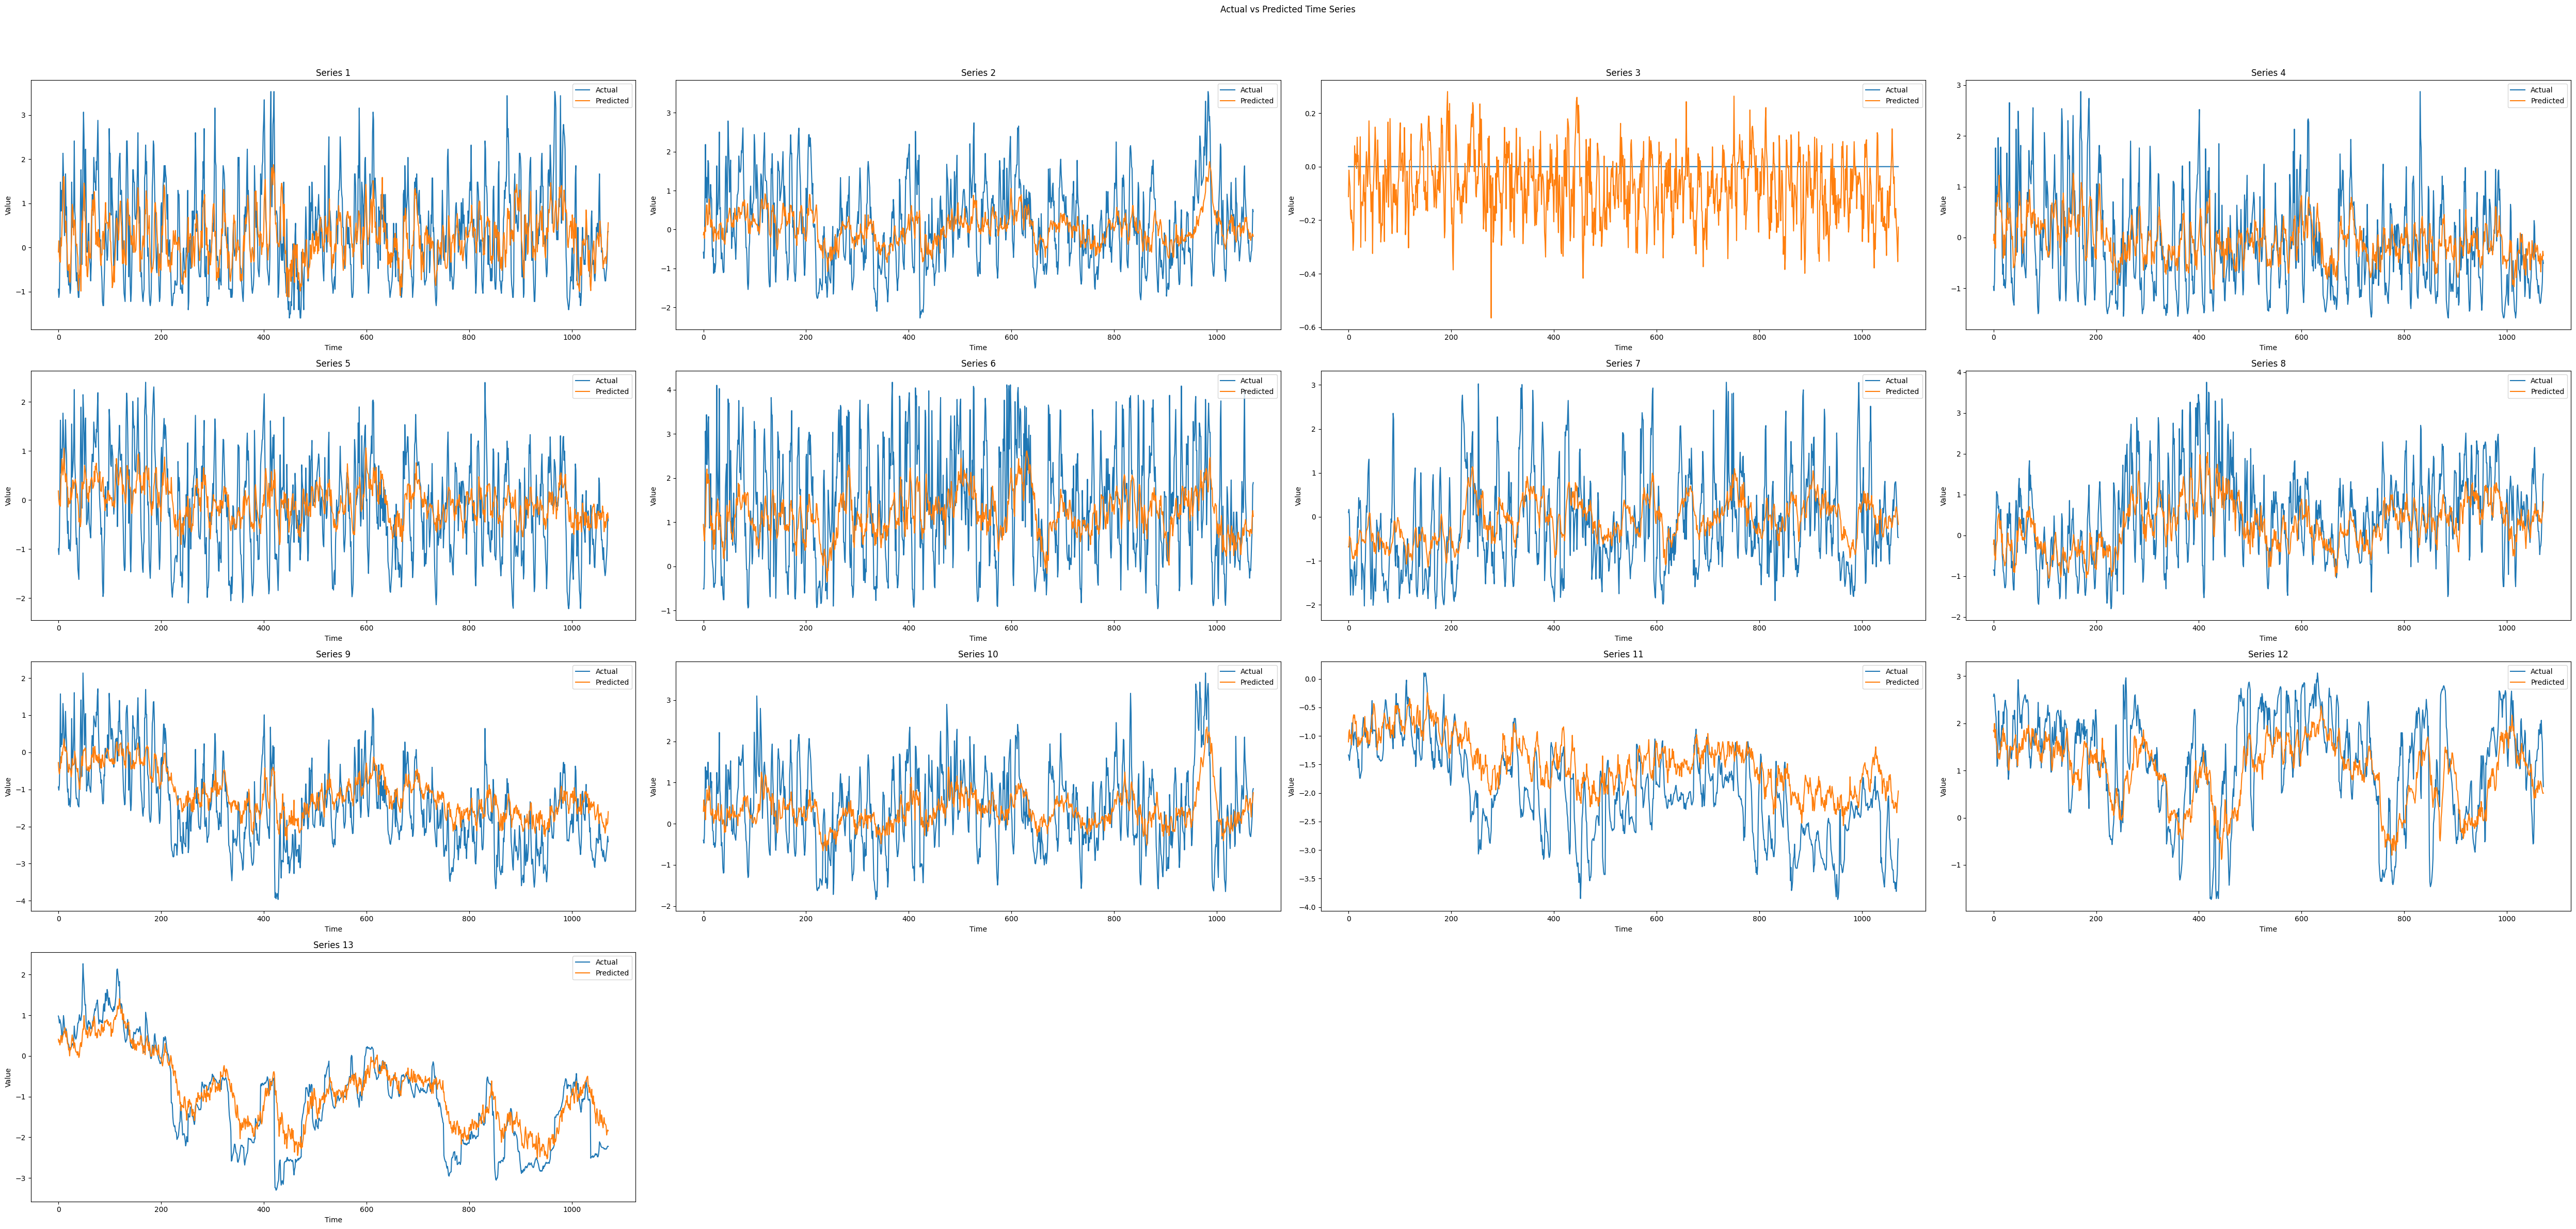

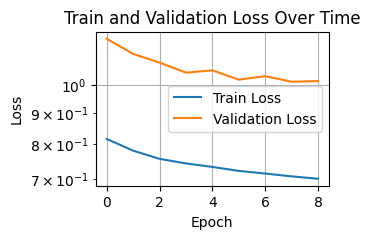

Saved model checkpoint at epoch 9 to /home/noam.koren/multiTS/NFT/models/NFT/trained_models/air_quality/trained_models/model_40l_30h_2blocks_tcn/models_during_train/model_checkpoint_epoch_9.pth
The min train loss is 0.6999627914955201 at epoch 9
The min val loss is 1.0116602182388306 at epoch 8



In [4]:
model = NFT(
    forecast_length=HORIZON,
    backcast_length=LOOKBACK,
    n_vars=NUM_OF_VARS,
    nb_blocks_per_stack=blocks,
    layers_type=layers_type,
    num_channels_for_tcn=[25, 50]
    ).to(device)

model.compile(loss='mse', optimizer='adam')

model.fit(
    x_train=train_X, 
    y_train=train_y, 
    validation_data=(val_X, val_y), 
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE, 
    plot_epoch=PLOT_EPOCH,
    path_to_save_model=path_to_save_checkpoint_models,
    path_to_save_loss_plots=path_to_save_loss_plots,
    path_to_save_prediction_plots=path_to_save_prediction_plots
    )

# train_pred, val_pred, test_pred = evaluate_model(model, train_X, train_y, val_X, val_y, test_X, test_y)


In [5]:
# train_pred, train_trend, train_seasonality = model.predict(train_X, return_interpretable=True, return_thetas=True) 
# val_pred, val_trend, val_seasonality = model.predict(val_X, return_interpretable=True, return_thetas=True)
f, trend_forecast, seasonality_forecast, trend_thetas, seasonality_thetas = model.predict(test_X, return_interpretable=True, return_thetas=True)

x: torch.Size([1643, 40, 13]), trend_forecast: torch.Size([1643, 30, 13]), trend_thetas: torch.Size([1643, 13, 4])


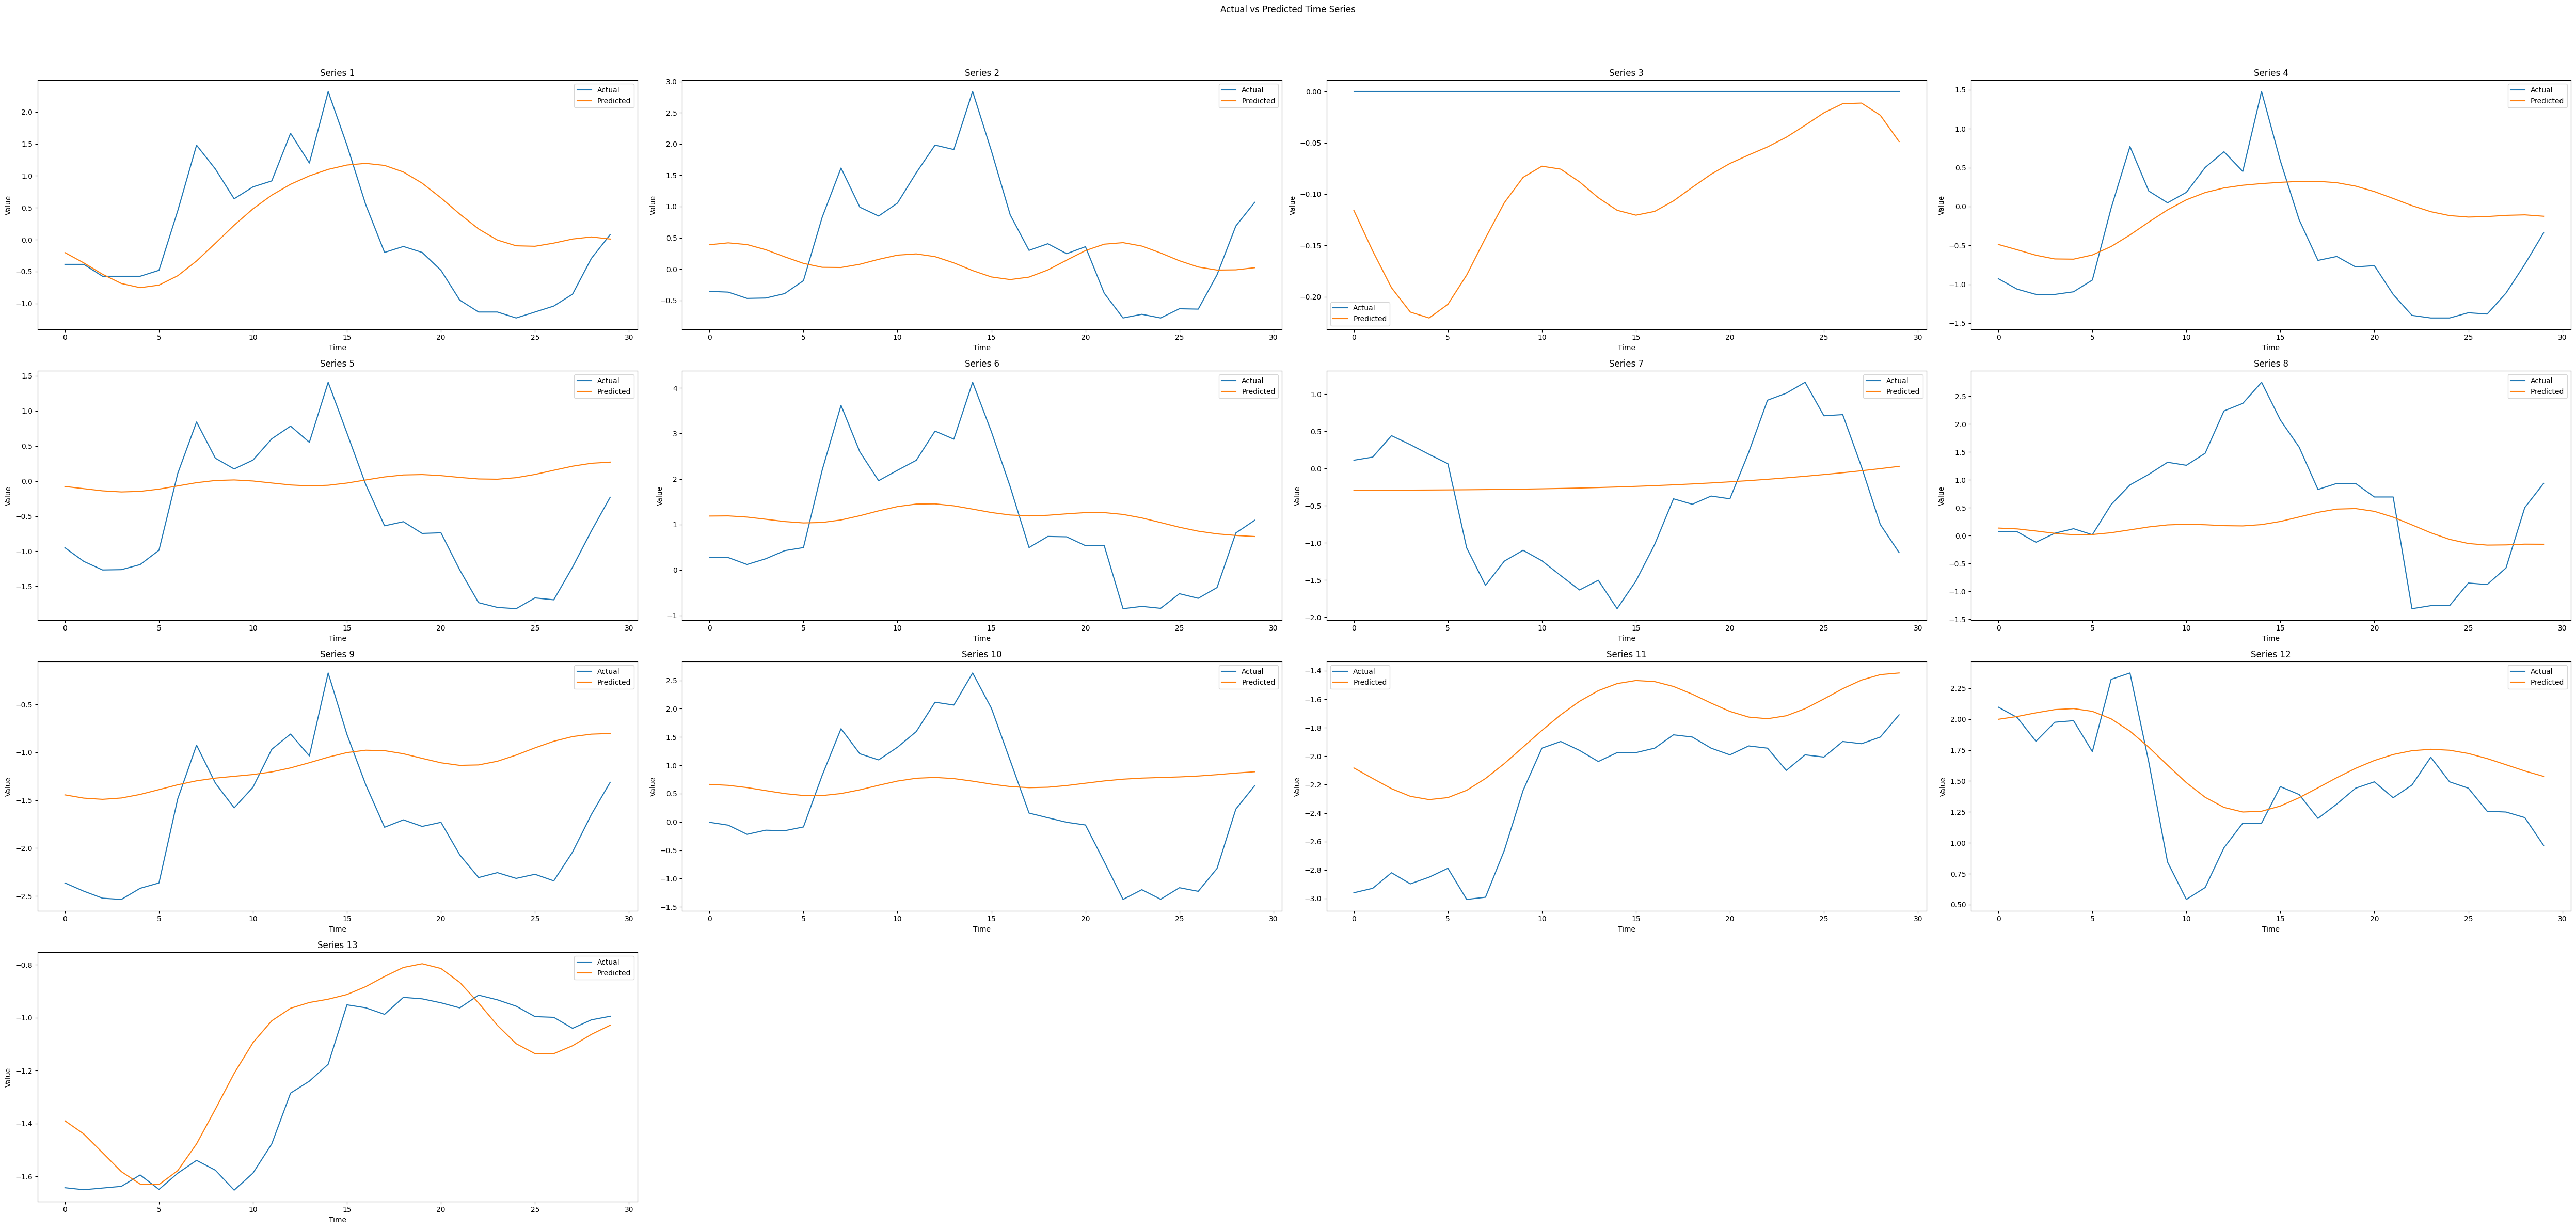

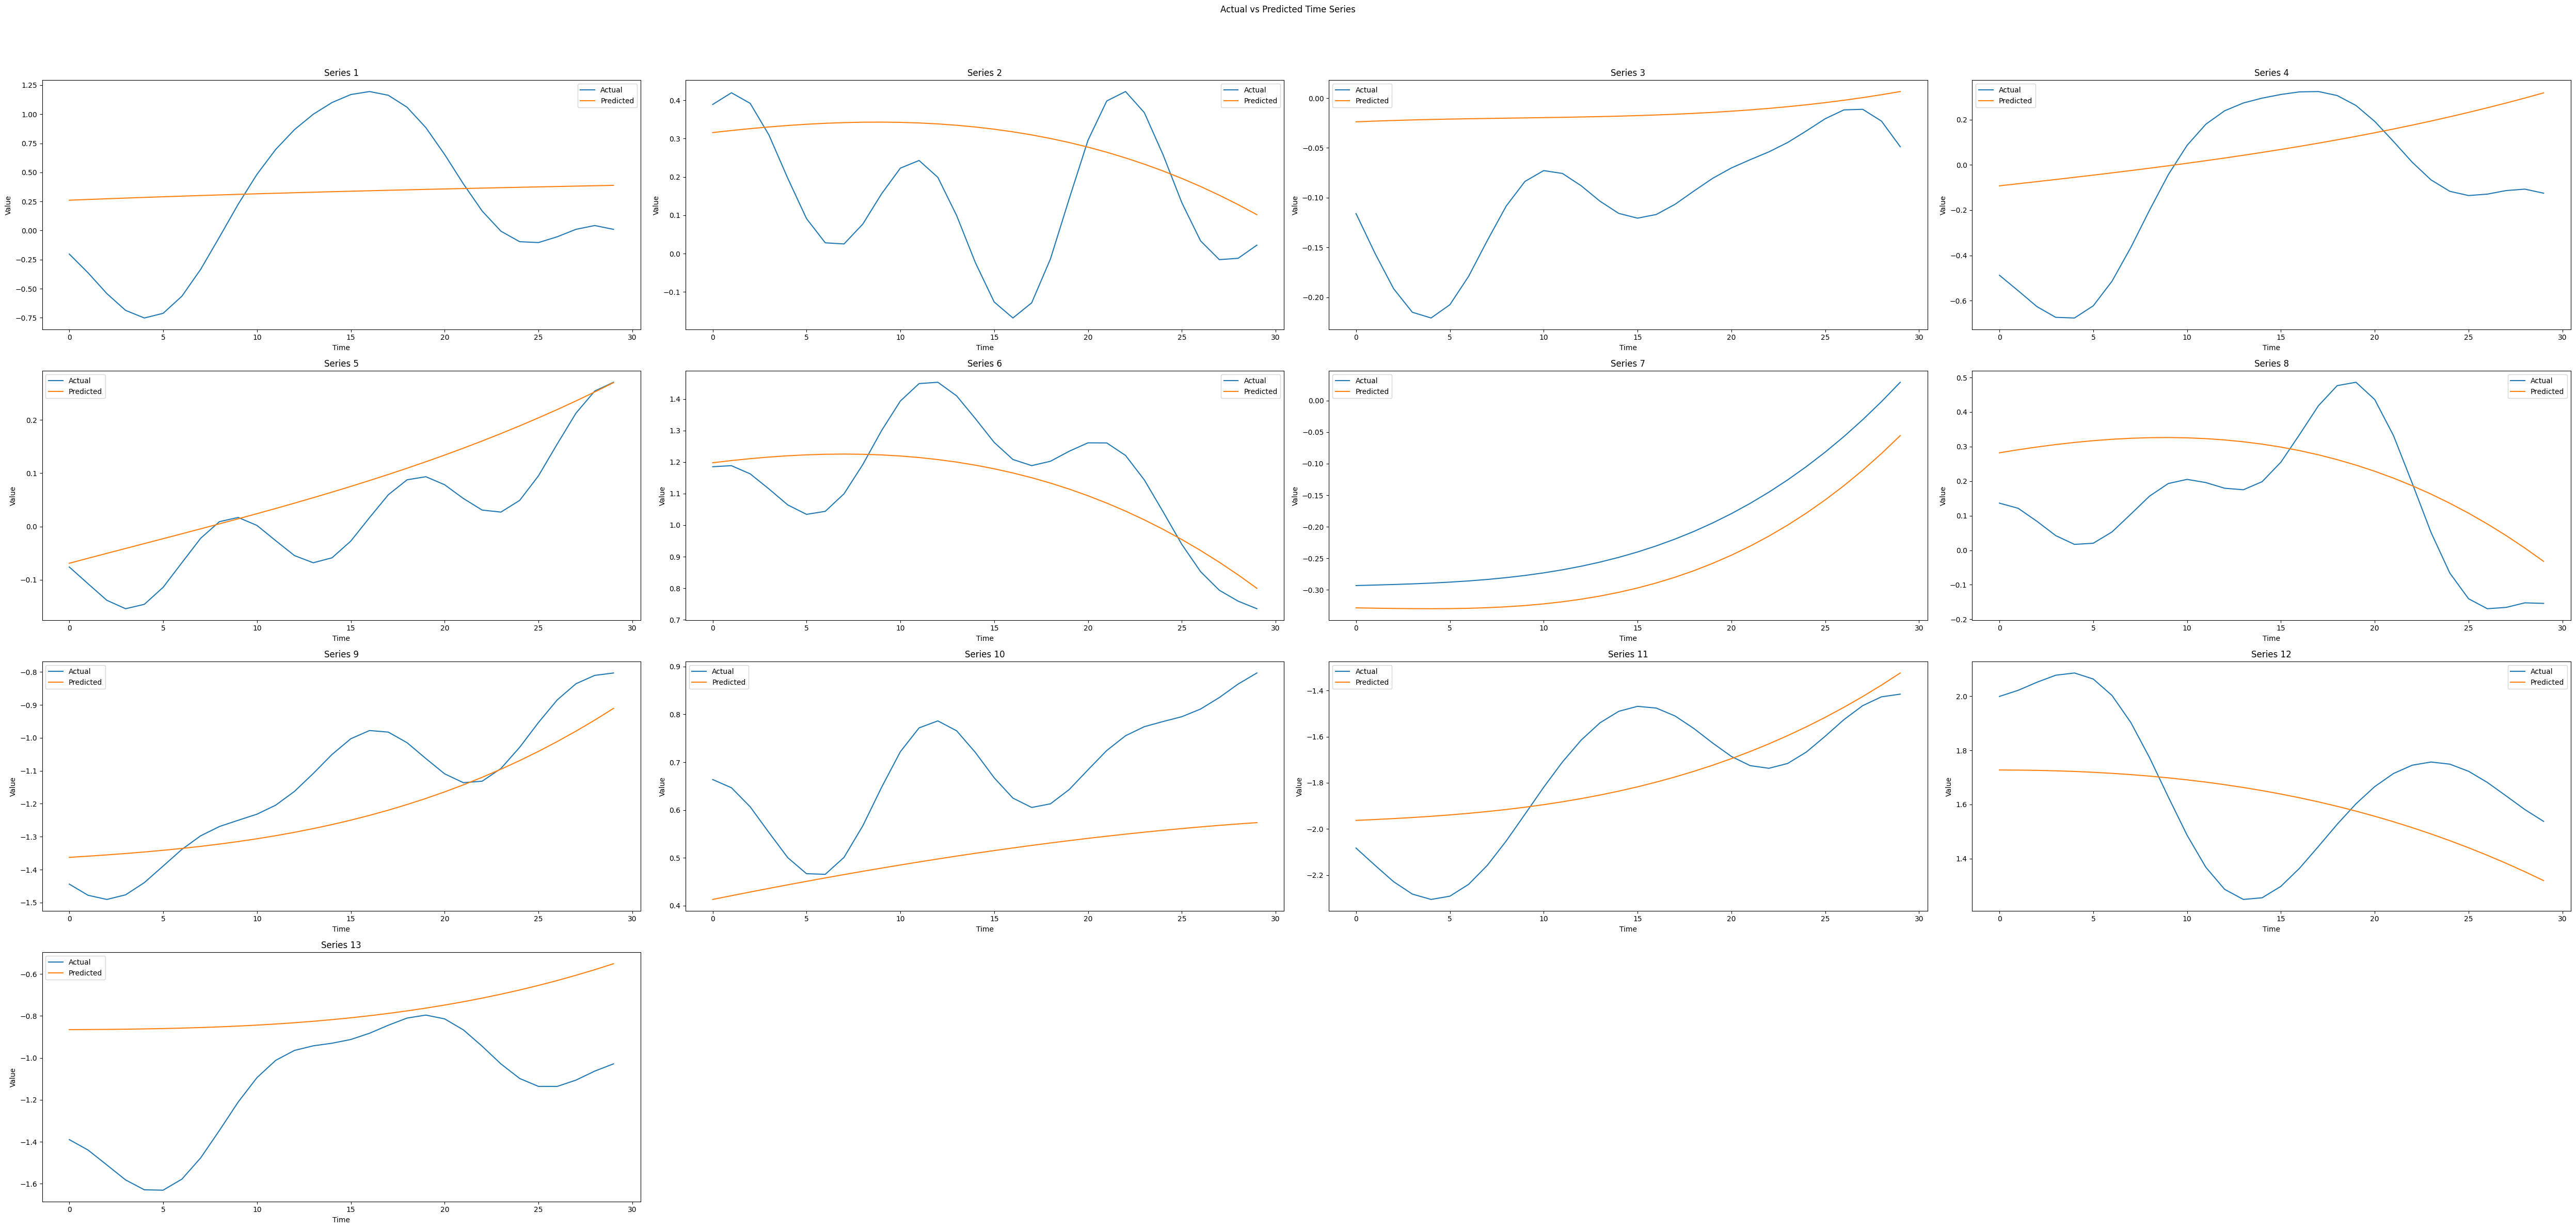

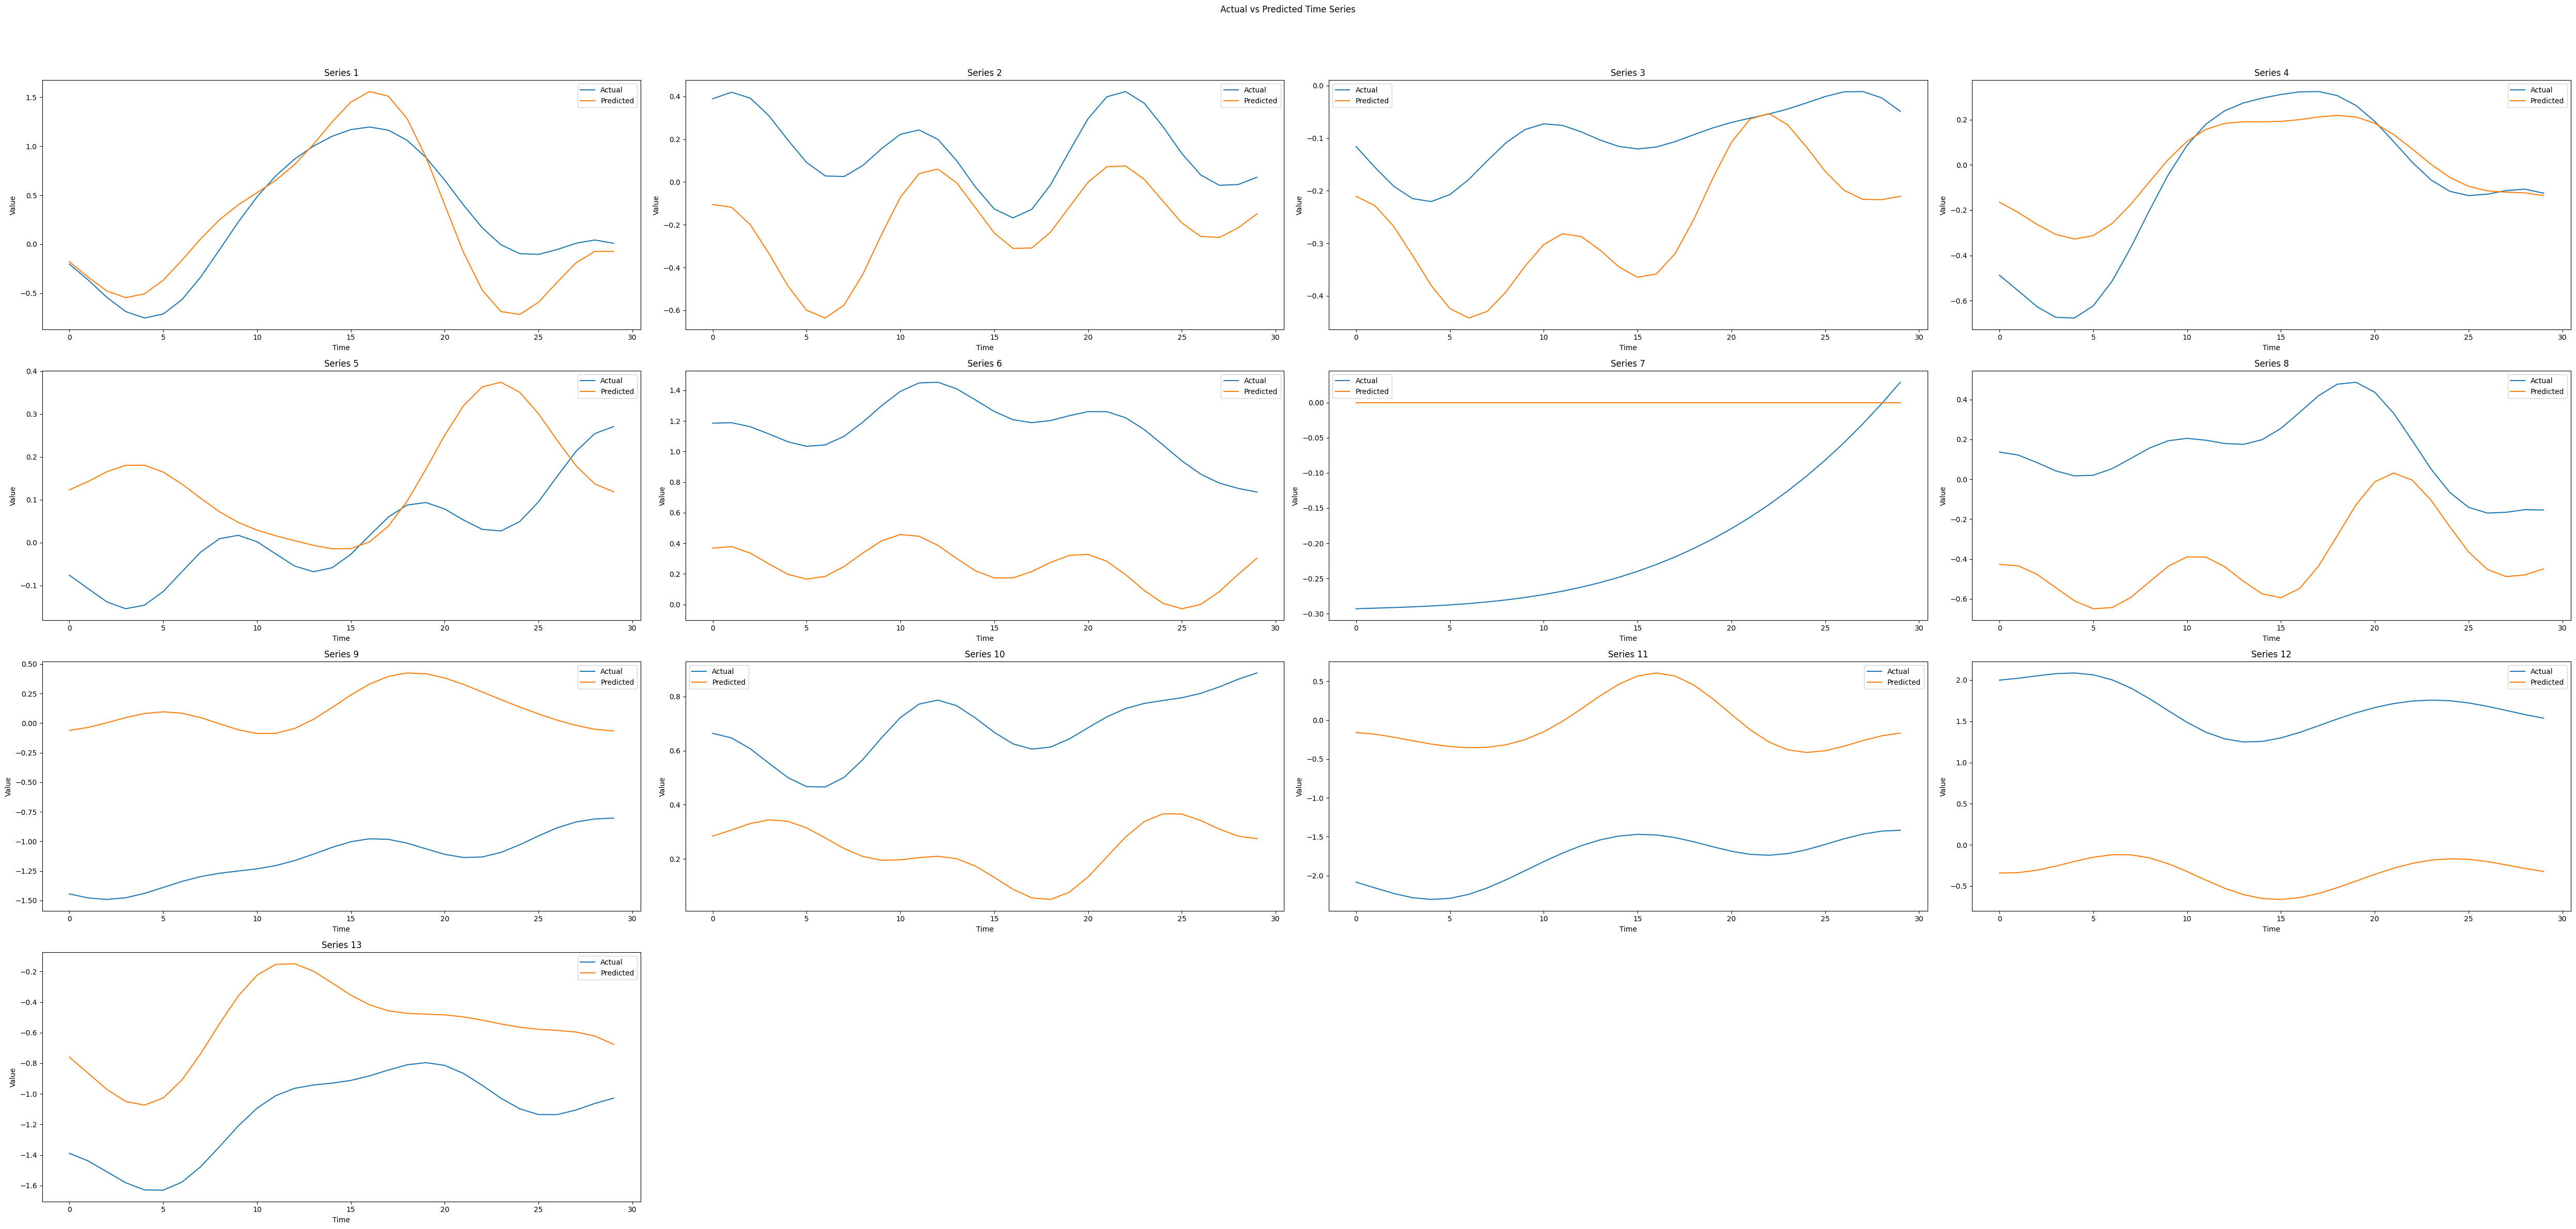

In [6]:
plot_specific_prediction(y=test_y, predictions=f, idx=0, horizon=HORIZON, n_vars=NUM_OF_VARS)
plot_specific_prediction(y=f, predictions=trend_forecast, idx=0, horizon=HORIZON, n_vars=NUM_OF_VARS)
plot_specific_prediction(y=f, predictions=seasonality_forecast, idx=0, horizon=HORIZON, n_vars=NUM_OF_VARS)


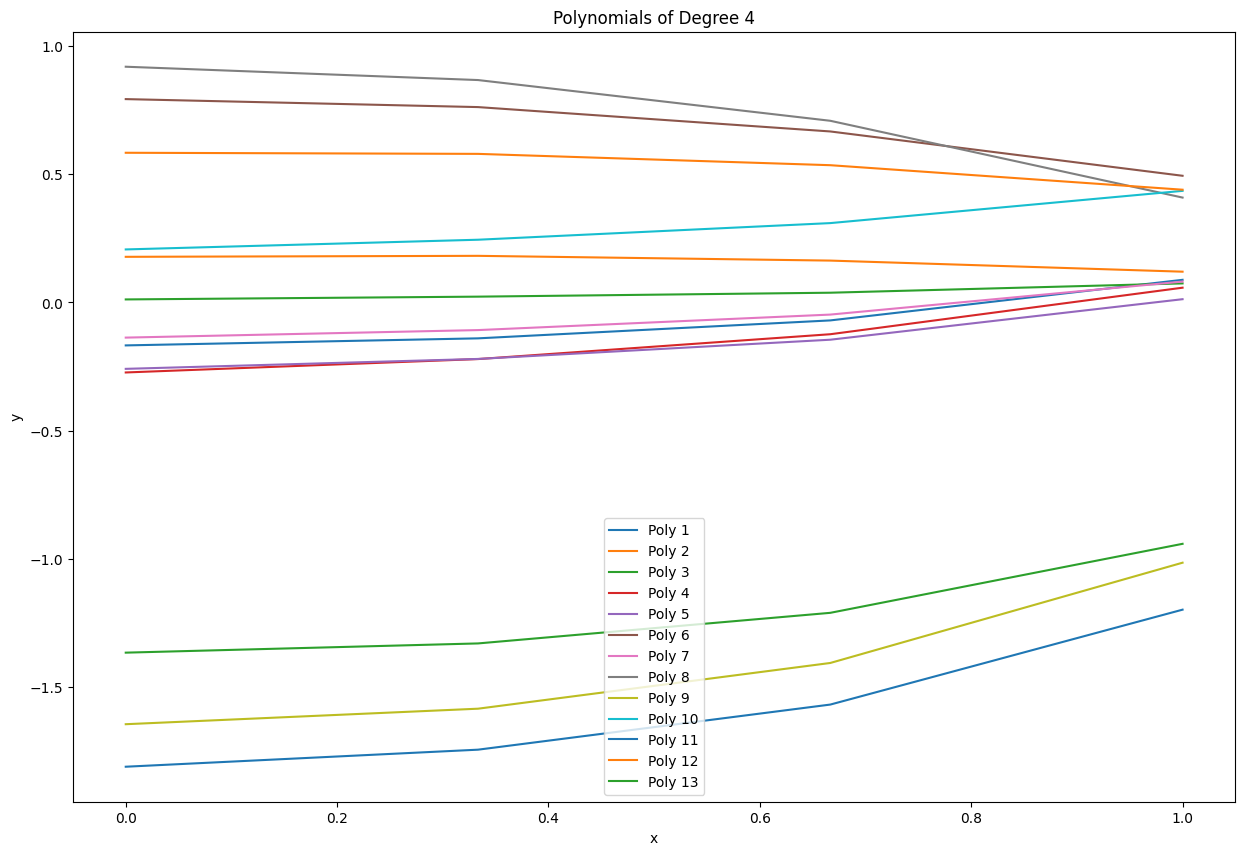

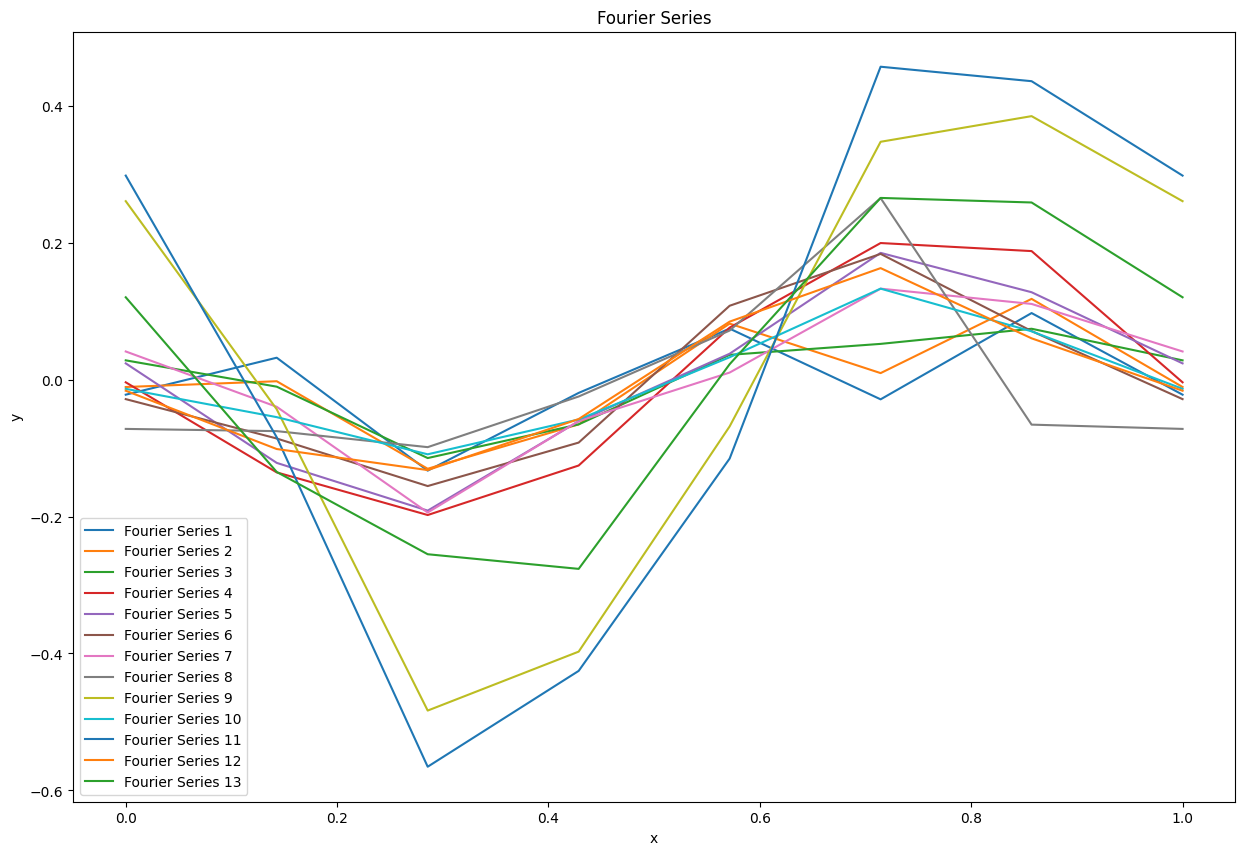

In [7]:
plot_poly(trend_thetas)
plot_fourier(seasonality_thetas)